# **Part 1: Text Classification** #

# Step 1.1: Loading and Preprocessing the 20 Newsgroups Dataset

Using TensorFlow backend.


Sample post: From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)
Subject: Diamond SS24X, Win 3.1, Mouse cursor
Organization: National Library of Medicine
Lines: 10


Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
Sorry, don't know the version of the driver (no indication in the menus) but it's a recently
delivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered
if anyone else had seen this.

post or email

--Don Lindbergh
dabl2@lhc.nlm.nih.gov

Sample target: 2
Training samples: 11314
Test samples: 7532
Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Found 134142 unique tokens.
Av

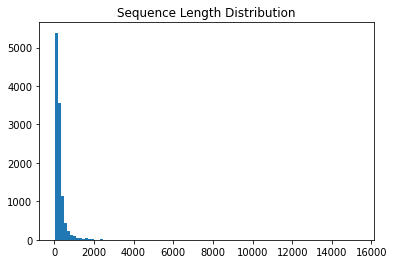

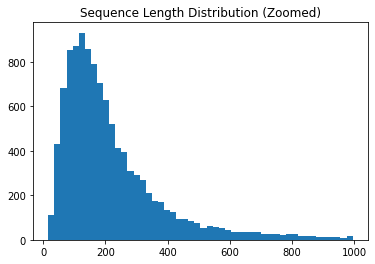

Shape of training data: (11314, 1000)
Shape of test data: (7532, 1000)
Shape of label tensor: (11314, 20)


In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the dataset
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
print("Sample post:", newsgroups_train['data'][1000])
print("Sample target:", newsgroups_train['target'][1000])
print("Training samples:", len(newsgroups_train['data']))
print("Test samples:", len(newsgroups_test['data']))

# Target names
target_names = newsgroups_train["target_names"]
print("Classes:", target_names)

# Tokenize the text
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(newsgroups_train["data"])
sequences = tokenizer.texts_to_sequences(newsgroups_train["data"])
sequences_test = tokenizer.texts_to_sequences(newsgroups_test["data"])
word_index = tokenizer.word_index
index_word = tokenizer.index_word
print('Found %s unique tokens.' % len(word_index))

# Analyze sequence lengths
seq_lens = [len(s) for s in sequences]
print("Average length:", np.mean(seq_lens))
print("Max length:", max(seq_lens))
plt.hist(seq_lens, bins=100)
plt.title("Sequence Length Distribution")
plt.show()
plt.hist([l for l in seq_lens if l < 1000], bins=50)
plt.title("Sequence Length Distribution (Zoomed)")
plt.show()

# Pad sequences
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of training data:', x_train.shape)
print('Shape of test data:', x_test.shape)

# Convert labels to one-hot encoding
y_train = to_categorical(newsgroups_train["target"])
y_test = newsgroups_test["target"]
print('Shape of label tensor:', y_train.shape)

# Step 1.2: Building a Simple CBOW Model

In [2]:
from keras.layers import Dense, Input, GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

# Build the model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True)
embedded_sequences = embedding_layer(sequence_input)
average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

# Train the model
history = model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=128, verbose=1)

# Evaluate on test set
test_pred = model.predict(x_test)
test_classes = np.argmax(test_pred, axis=-1)
test_acc = np.mean(test_classes == y_test)
print("Test accuracy:", test_acc)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
Total params: 1,001,020
Trainable params: 1,001,020
Non-trainable params: 0
_________________________________________________________________
None

Train on 10182 samples, validate on 1132 samples
Epoch 1/10
10182/10182 [==============================] - 8s 762us/step - loss: 2.9888 - acc: 0.0715 - val_loss

# Step 1.3: Building a More Complex Model with Conv1D


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0  

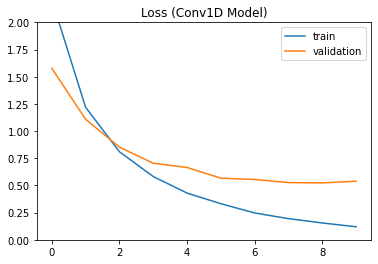

In [3]:
from keras.layers import Conv1D, MaxPooling1D

# Build the Conv1D model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = GlobalAveragePooling1D()(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model_conv = Model(sequence_input, predictions)
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model_conv.summary())

# Train the model
history_conv = model_conv.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=128, verbose=1)

# Evaluate on test set
test_pred_conv = model_conv.predict(x_test)
test_classes_conv = np.argmax(test_pred_conv, axis=-1)
print("Test accuracy (Conv1D):", np.mean(test_classes_conv == y_test))

# Plot loss
plt.plot(history_conv.history['loss'], label='train')
plt.plot(history_conv.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss (Conv1D Model)')
plt.show()

# Step 1.4: Building a Model with LSTM

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 64)           16064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 199, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 64)           20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                3302

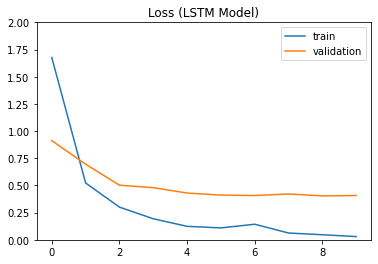

In [4]:
from keras.layers import LSTM

# Build the LSTM model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = LSTM(64)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model_lstm = Model(sequence_input, predictions)
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model_lstm.summary())

# Train the model
history_lstm = model_lstm.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=128, verbose=1)

# Evaluate on test set
test_pred_lstm = model_lstm.predict(x_test)
test_classes_lstm = np.argmax(test_pred_lstm, axis=-1)
print("Test accuracy (LSTM):", np.mean(test_classes_lstm == y_test))

# Plot loss
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss (LSTM Model)')
plt.show()

# Step 1.5: Visualizing Word Embeddings with t-SNE

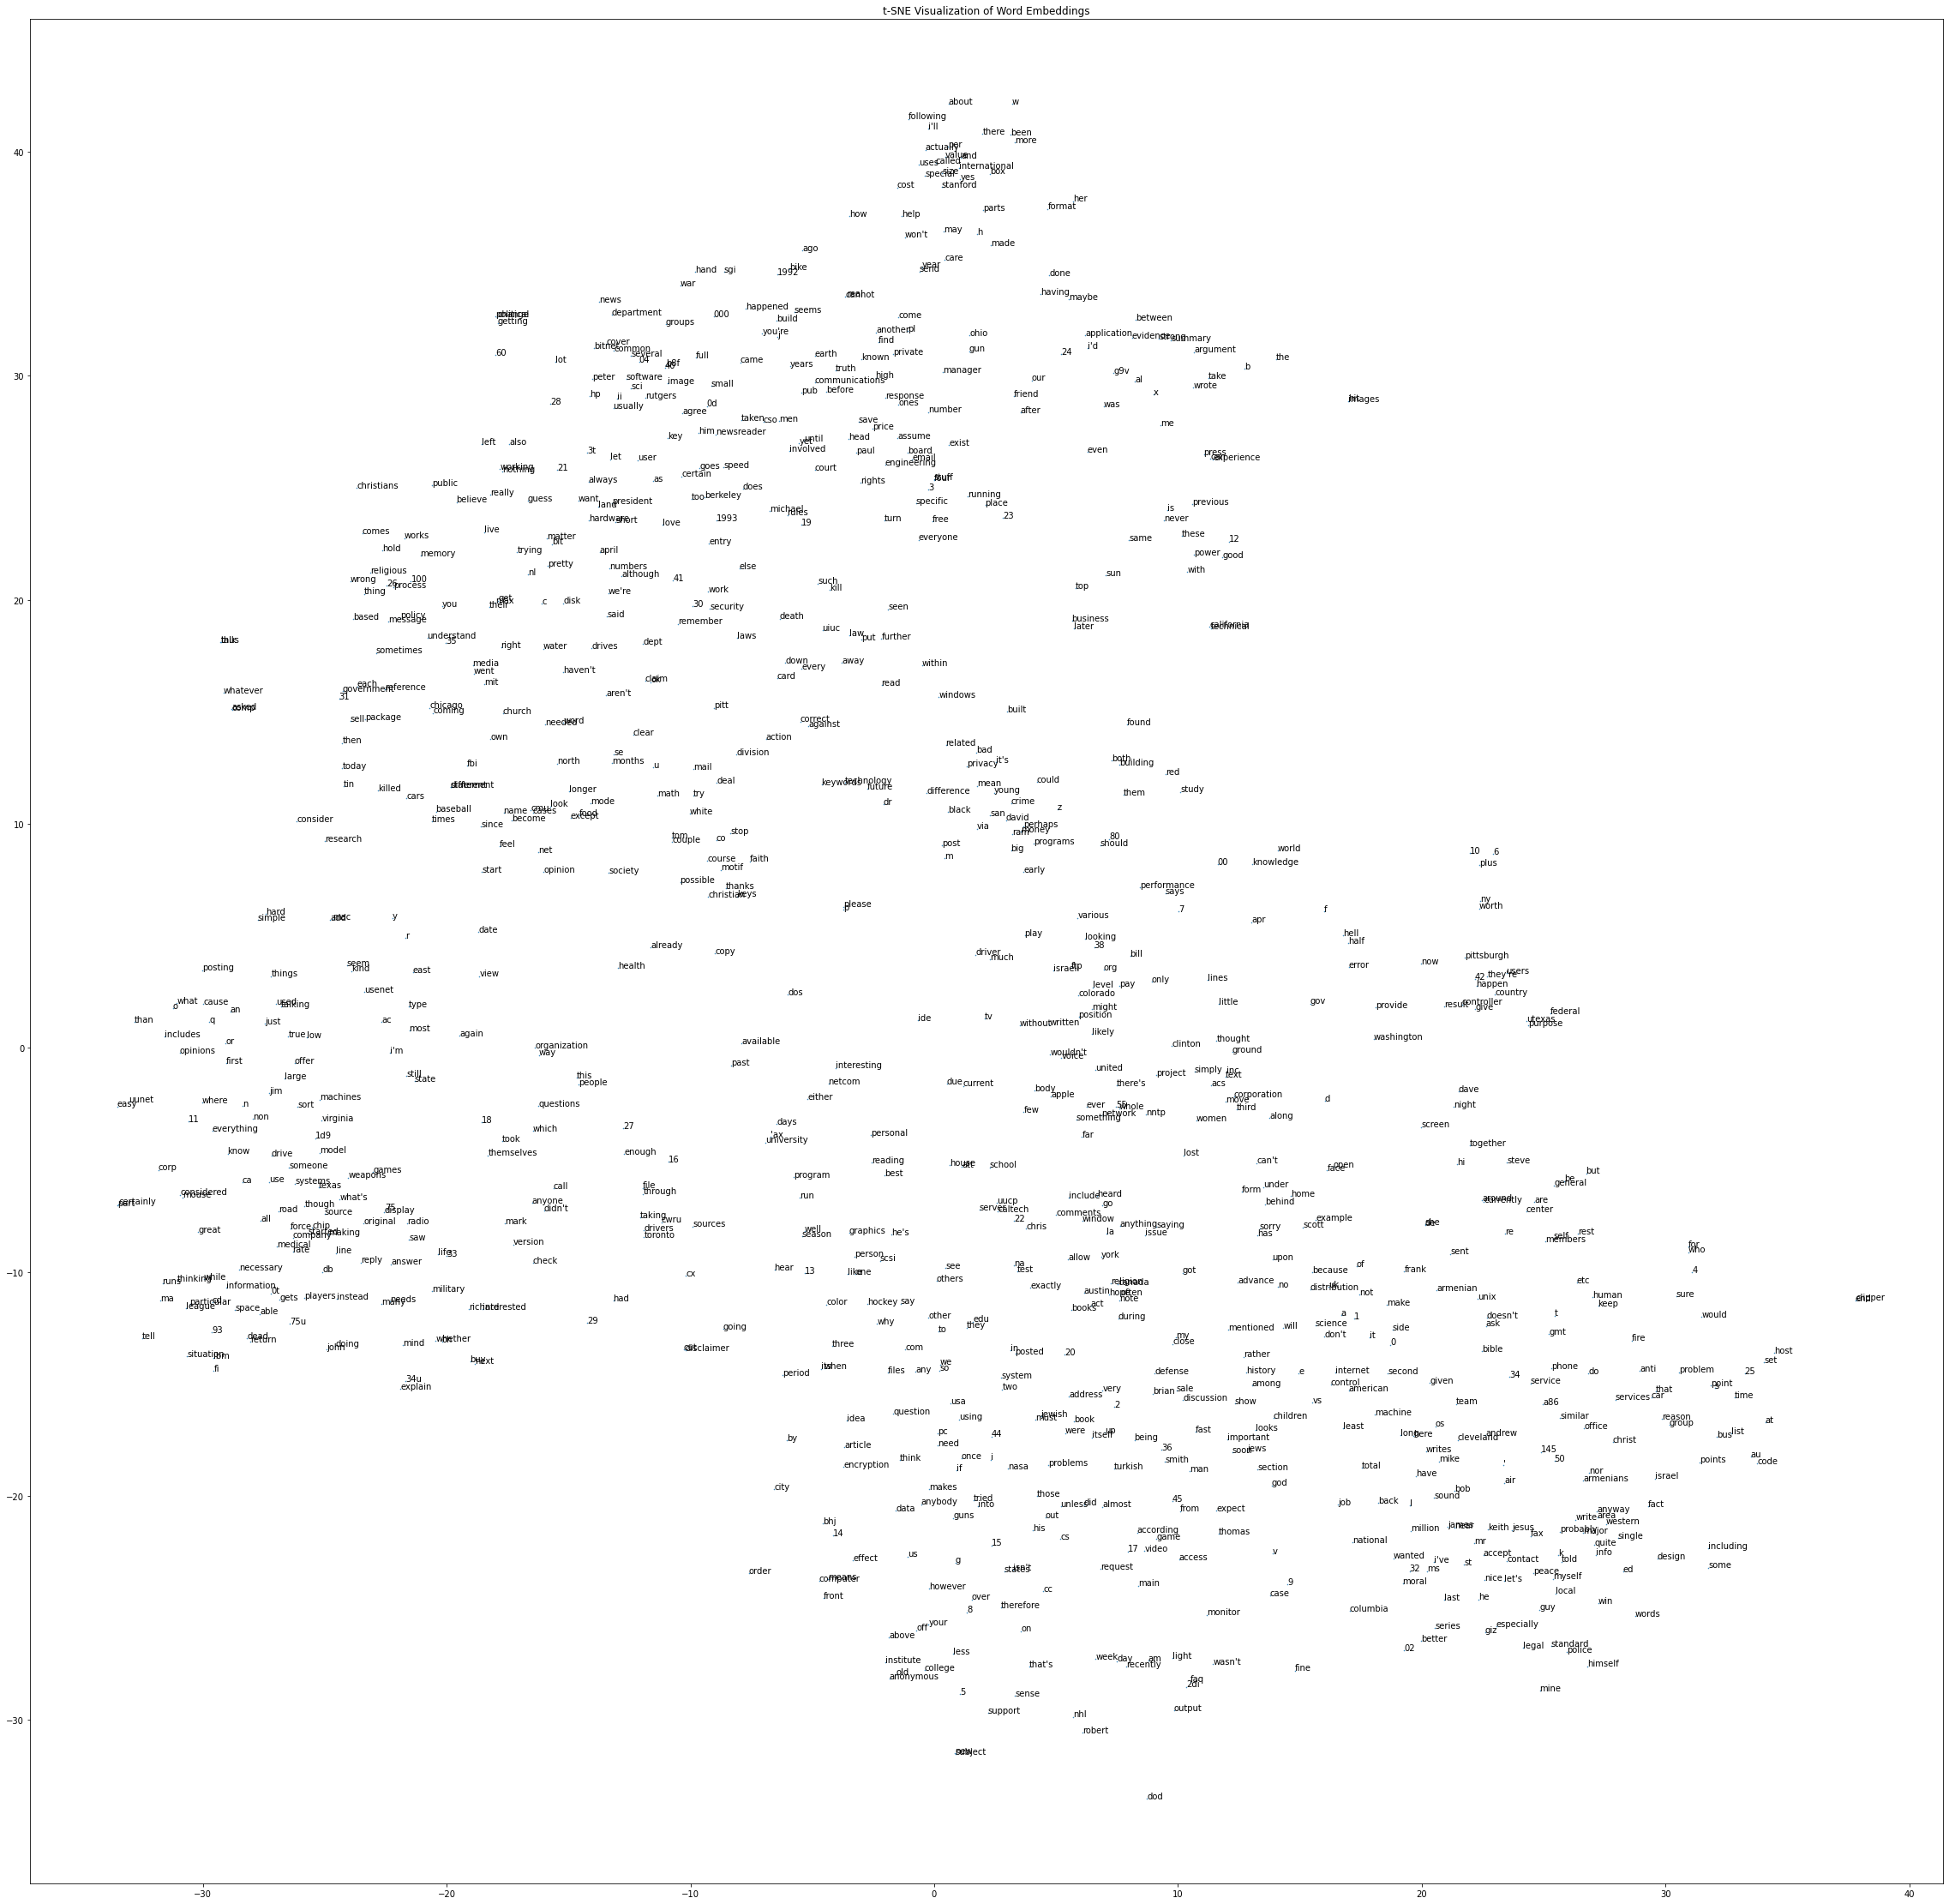

In [5]:
from sklearn.manifold import TSNE

# Extract embeddings
embeddings = model_lstm.layers[1].get_weights()[0]
embeddings = np.vstack(embeddings)
norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
embeddings_normed = embeddings / norms

# Apply t-SNE
word_emb_tsne = TSNE(perplexity=30).fit_transform(embeddings_normed[:1000])

# Plot
plt.figure(figsize=(40, 40))
plt.scatter(word_emb_tsne[:, 0], word_emb_tsne[:, 1], marker=".", s=1)
for idx in range(1000):
    plt.annotate(index_word[idx+1], xy=(word_emb_tsne[idx, 0], word_emb_tsne[idx, 1]),
                 xytext=(0, 0), textcoords='offset points')
plt.title("t-SNE Visualization of Word Embeddings")
plt.show()

# **Part 2: Seq2Seq Translation** #

# Step 2.1: Generating the Dataset #

In [6]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from random import Random
from math import log10

# Import from french_numbers.py
from Files.french_numbers import (
    START_VOCAB, _PAD as PAD, _GO as GO, _EOS as EOS, _UNK as UNK,
    PAD_ID, GO_ID, EOS_ID, UNK_ID,
    generate_translations, tokenize, sentence_to_token_ids, token_ids_to_sentence,
    build_vocabulary
)

# Generate and split the dataset
numbers, french_numbers = generate_translations(low=1, high=int(1e6) - 1, exhaustive=5000, random_seed=0)
num_train, num_dev, fr_train, fr_dev = train_test_split(numbers, french_numbers, test_size=0.5, random_state=0)
num_val, num_test, fr_val, fr_test = train_test_split(num_dev, fr_dev, test_size=0.5, random_state=0)

# Print dataset sizes
print("Training samples:", len(fr_train))
print("Validation samples:", len(fr_val))
print("Test samples:", len(fr_test))

# Sample data
for i, (fr_phrase, num_phrase) in enumerate(zip(fr_train[:5], num_train[:5])):
    print(f"{num_phrase.rjust(6)} {fr_phrase}")

Training samples: 10000
Validation samples: 5000
Test samples: 5000
  2882 deux mille huit cent quatre vingt deux
372200 trois cent soixante douze mille deux cents
  2193 deux mille cent quatre vingt treize
996418 neuf cent quatre vingt seize mille quatre cent dix huit
  9172 neuf mille cent soixante douze


# Step 2.2: Building Vocabularies #

In [7]:
# Build separate vocabularies using build_vocabulary from french_numbers.py
fr_vocab, rev_fr_vocab = build_vocabulary(fr_train, word_level=True)
num_vocab, rev_num_vocab = build_vocabulary(num_train, word_level=False)

# Build a shared vocabulary with explicit deduplication
shared_tokens = set(START_VOCAB)  # Start with special tokens
# Add French tokens
fr_tokens = [token for token in rev_fr_vocab if token not in START_VOCAB]
shared_tokens.update(fr_tokens)
# Add numeric tokens
num_tokens = [token for token in rev_num_vocab if token not in START_VOCAB]
shared_tokens.update(num_tokens)
# Convert to a sorted list for shared_rev_vocab
shared_rev_vocab = START_VOCAB + sorted(shared_tokens - set(START_VOCAB))
shared_vocab = {token: i for i, token in enumerate(shared_rev_vocab)}

# Print vocabulary information
print("Shared vocabulary size:", len(shared_vocab))
print("Sample shared vocab (first 10):", shared_rev_vocab[:10])
print("Sample shared vocab (last 10):", shared_rev_vocab[-10:])

Shared vocabulary size: 40
Sample shared vocab (first 10): ['_PAD', '_GO', '_EOS', '_UNK', '0', '1', '2', '3', '4', '5']
Sample shared vocab (last 10): ['seize', 'sept', 'six', 'soixante', 'treize', 'trente', 'trois', 'un', 'vingt', 'vingts']


# Step 2.3: Preparing Input and Output Sequences for Seq2Seq

In [8]:
# Define function to create input and output tokens
def make_input_output(source_tokens, target_tokens, reverse_source=True):
    input_tokens = source_tokens[::-1] if reverse_source else source_tokens
    input_tokens += [GO]
    input_tokens += target_tokens
    output_tokens = target_tokens + [EOS]
    return input_tokens, output_tokens

# Test the function
input_tokens, output_tokens = make_input_output(['quatre', 'cent', 'soixante', 'seize'], ['4', '7', '6'])
print("Input tokens:", input_tokens)
print("Output tokens:", output_tokens)

# Vectorize the corpus
max_length = 20

def vectorize_corpus(source_sequences, target_sequences, shared_vocab, word_level_source=True, word_level_target=True, max_length=max_length):
    assert len(source_sequences) == len(target_sequences)
    n_sequences = len(source_sequences)
    source_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    source_ids.fill(PAD_ID)
    target_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    target_ids.fill(PAD_ID)
    for i, (source_seq, target_seq) in enumerate(zip(source_sequences, target_sequences)):
        source_tokens = tokenize(source_seq, word_level=word_level_source)
        target_tokens = tokenize(target_seq, word_level=word_level_target)
        in_tokens, out_tokens = make_input_output(source_tokens, target_tokens)
        in_token_ids = [shared_vocab.get(t, UNK_ID) for t in in_tokens]
        source_ids[i, -len(in_token_ids):] = in_token_ids
        out_token_ids = [shared_vocab.get(t, UNK_ID) for t in out_tokens]
        target_ids[i, -len(out_token_ids):] = out_token_ids
    return source_ids, target_ids

# Vectorize datasets
X_train, Y_train = vectorize_corpus(fr_train, num_train, shared_vocab, word_level_target=False)
X_val, Y_val = vectorize_corpus(fr_val, num_val, shared_vocab, word_level_target=False)
X_test, Y_test = vectorize_corpus(fr_test, num_test, shared_vocab, word_level_target=False)

# Print sample sequences
print("Sample input sequence:", X_train[5])
print("Sample output sequence:", Y_train[5])
print("Corresponding French phrase:", fr_train[5])
print("Corresponding number:", num_train[5])

Input tokens: ['seize', 'soixante', 'cent', 'quatre', '_GO', '4', '7', '6']
Output tokens: ['4', '7', '6', '_EOS']
Sample input sequence: [ 0  0  0  0  0  0  0  0  0  0  0  0 30 33 14 28  1  8 11 10]
Sample output sequence: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8 11 10  2]
Corresponding French phrase: quatre cent soixante seize
Corresponding number: 476


# Step 2.4: Building the Seq2Seq Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 32)            1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 64)            18624     
_________________________________________________________________
dense_4 (Dense)              (None, 20, 40)            2600      
Total params: 22,504
Trainable params: 22,504
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10000 samples, validate on 5000 samples
Epoch 1/15
 - 7s - loss: 1.0698 - val_loss: 0.6110

Epoch 00001: val_loss improved from inf to 0.611

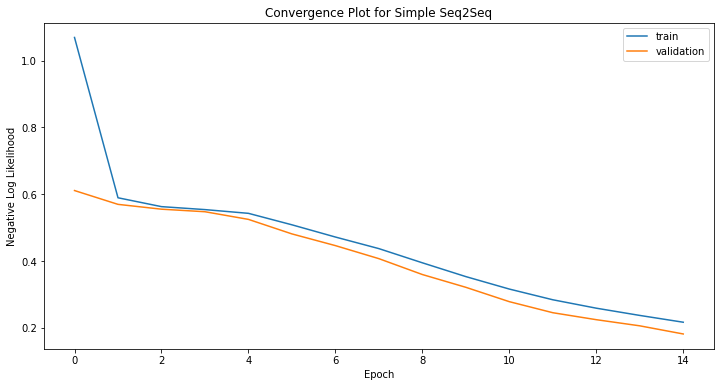

AttributeError: 'str' object has no attribute 'decode'

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, GRU, Dense

# Build the Seq2Seq model
vocab_size = len(shared_vocab)
embedding_dim = 32
gru_units = 64

simple_seq2seq = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Dropout(0.2),
    GRU(gru_units, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

simple_seq2seq.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
print(simple_seq2seq.summary())

# Train the model with a checkpoint
from keras.callbacks import ModelCheckpoint

best_model_fname = "Files/simple_seq2seq_checkpoint.h5"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_loss', save_best_only=True, verbose=1)

history = simple_seq2seq.fit(
    X_train, np.expand_dims(Y_train, -1), 
    validation_data=(X_val, np.expand_dims(Y_val, -1)), 
    epochs=15, batch_size=32, verbose=2, callbacks=[best_model_cb])

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('Epoch')
plt.title('Convergence Plot for Simple Seq2Seq')
plt.legend()
plt.show()

# Load the best model
from keras.models import load_model
simple_seq2seq = load_model(best_model_fname, compile=False)

# Step 2.5: Decoding and Evaluating the Seq2Seq Model

In [10]:
def greedy_translate(model, source_sequence, shared_vocab, shared_rev_vocab,
                     word_level_source=True, word_level_target=True):
    source_tokens = tokenize(source_sequence, word_level=word_level_source)
    input_ids = [shared_vocab.get(t, UNK_ID) for t in source_tokens[::-1]]
    input_ids += [shared_vocab[GO]]
    input_array = np.empty(shape=(1, model.input_shape[1]), dtype=np.int32)
    decoded_tokens = []
    while len(input_ids) <= max_length:
        input_array.fill(PAD_ID)
        input_array[0, -len(input_ids):] = input_ids
        next_token_id = model.predict(input_array, verbose=0)[0, -1].argmax()
        if next_token_id == shared_vocab[EOS]:
            break
        decoded_tokens.append(shared_rev_vocab[next_token_id])
        input_ids.append(next_token_id)
    separator = " " if word_level_target else ""
    return separator.join(decoded_tokens)

# Test some translations
phrases = [
    "un", "deux", "trois", "onze", "quinze", "cent trente deux",
    "cent mille douze", "sept mille huit cent cinquante neuf",
    "vingt et un", "vingt quatre", "quatre vingts",
    "quatre vingt onze mille", "quatre vingt onze mille deux cent deux"
]
for phrase in phrases:
    translation = greedy_translate(simple_seq2seq, phrase, shared_vocab, shared_rev_vocab, word_level_target=False)
    print(phrase.ljust(40), translation)

print("\n___DECODING___\n")

# Evaluate phrase-level accuracy
def phrase_accuracy(model, num_sequences, fr_sequences, n_samples=300, decoder_func=greedy_translate):
    correct = []
    n_samples = min(n_samples, len(num_sequences))
    for i, (num_seq, fr_seq) in enumerate(zip(num_sequences[:n_samples], fr_sequences[:n_samples])):
        if i % 100 == 0:
            print(f"Decoding {i}/{n_samples}")
        predicted_seq = decoder_func(model, fr_seq, shared_vocab, shared_rev_vocab, word_level_target=False)
        correct.append(num_seq == predicted_seq)
    return np.mean(correct)

print(f"Phrase-level test accuracy: {phrase_accuracy(simple_seq2seq, num_test, fr_test)}\n")
print(f"Phrase-level train accuracy: {phrase_accuracy(simple_seq2seq, num_train, fr_train)}\n")

un                                       10
deux                                     26
trois                                    30
onze                                     100
quinze                                   15
cent trente deux                         132
cent mille douze                         111
sept mille huit cent cinquante neuf      7859
vingt et un                              201
vingt quatre                             208
quatre vingts                            80
quatre vingt onze mille                  911
quatre vingt onze mille deux cent deux   9212

___DECODING___

Decoding 0/300
Decoding 100/300
Decoding 200/300
Phrase-level test accuracy: 0.08333333333333333

Decoding 0/300
Decoding 100/300
Decoding 200/300
Phrase-level train accuracy: 0.09666666666666666

